# XY heatmap
Show where in the arena spikes occur for each unit

In [1]:
# imports
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import medfilt

sys.path.append("./")
sys.path.append(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion")

from data.dbase.db_tables import Probe, Unit, Session, ValidatedSession, Recording, Tracking
from data.data_utils import convolve_with_gaussian

from fcutils.maths.signals import get_onset_offset
from fcutils.plot.figure import clean_axes, calc_nrows_ncols
from myterial import amber_darker, green_dark, grey_darker, blue_darker, grey


save_folder = Path(r"D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys")


# print all available recordings
print(*zip(*Recording().fetch("name", "recording_probe_configuration")), sep="\n")

[06/04/22 10:17:19] DEBUG    DPL - Saving data and logs to logs                   ]8;id=883513;file://c:\ProgramData\Miniconda3\envs\dev\lib\site-packages\tpd\core.py\core.py]8;;\:]8;id=813672;file://c:\ProgramData\Miniconda3\envs\dev\lib\site-packages\tpd\core.py#118\118]8;;\

                    DEBUG    Saving log file to: logs\log.log                     ]8;id=743914;file://c:\ProgramData\Miniconda3\envs\dev\lib\site-packages\tpd\core.py\core.py]8;;\:]8;id=477205;file://c:\ProgramData\Miniconda3\envs\dev\lib\site-packages\tpd\core.py#119\119]8;;\

Connecting root@127.0.0.1:3306


[06/04/22 10:17:20] DEBUG    Connected to database: LOCOMOTION                 ]8;id=808008;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\data\dbase\__init__.py\__init__.py]8;;\:]8;id=112877;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\data\dbase\__init__.py#11\11]8;;\

('FC_210715_AAA1110750_r5_hairpin', 'longcolumn')
('FC_210716_AAA1110750_r6_hairpin', 'longcolumn')
('FC_210720_AAA1110750_hairpin', 'longcolumn')
('FC_210721_AAA1110750_hairpin', 'longcolumn')
('FC_210722_AAA1110750_hairpin', 'longcolumn')
('FC_220408_BAA1101192_hairpin', 'r72')
('FC_220409_BAA1101192_hairpin', 'r32')
('FC_220410_BAA1101192_hairpin', 'r64')
('FC_220411_BAA1101192_hairpin', 'r96')
('FC_220413_BAA1101192_hairpin', 'r96')
('FC_220414_BAA1101192_hairpin', 'r48')
('FC_220415_BAA1101192_hairpin', 'r96')
('FC_220432_BAA1101192_hairpin', 'r128')
('FC_220433_BAA1101192_hairpin', 'r128')
('FC_220434_BAA1101192_hairpin', 'r96')
('FC_220435_BAA1101192_hairpin', 'r64')
('FC_211022_BAA110516_hairpin', 'longcolumn')
('FC_211027_BAA110516_hairpin', 'longcolumn')
('FC_211214_BAA110517_hairpin', 'b0')
('FC_220114_BAA110517_hairpin', 'b0')
('FC_220117_BAA110517_hairpin', 'b0')
('FC_220119_BAA110517_hairpin', 'b0')
('FC_220120_BAA110517_hairpin', 'b0')
('FC_210917_BAA1110279_hairpin', 'b

In [2]:
REC = "FC_220408_BAA1101192_hairpin"

metadata = pd.DataFrame(
    (Recording & f'name="{REC}"').fetch()
)

tracking = Tracking.get_session_tracking(REC, body_only=True)
print(tracking)

units = pd.DataFrame(Unit * Unit.Spikes * Probe.RecordingSite & f'name="{REC}"')
units = units.sort_values("brain_region", inplace=False).reset_index()

mouse_id                                                   BAA1101192
name                                     FC_220408_BAA1101192_hairpin
bpname                                                           body
orientation         [20.46860604547166, 2.2873084308201896, 16.283...
angular_velocity    [1228.1163627282995, -1090.8778568790883, 839....
speed               [6.340201506833432, 2.301073842891923, 0.98136...
acceleration        [6.340201506833432, -4.039127663941509, -1.319...
theta               [336.12072186875093, 9.083940881123056, 2.8749...
thetadot            [20167.243312125058, 1977.7931407423273, -372....
thetadotdot         [20167.243312125058, -18189.45017138273, -2350...
x                   [11.474095674820452, 11.417840250675154, 11.43...
y                   [4.503422038204072, 4.419646329903848, 4.44418...
bp_speed            [6.340201506833432, 2.301073842891923, 0.98136...
moving              [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
walking             

## make plot

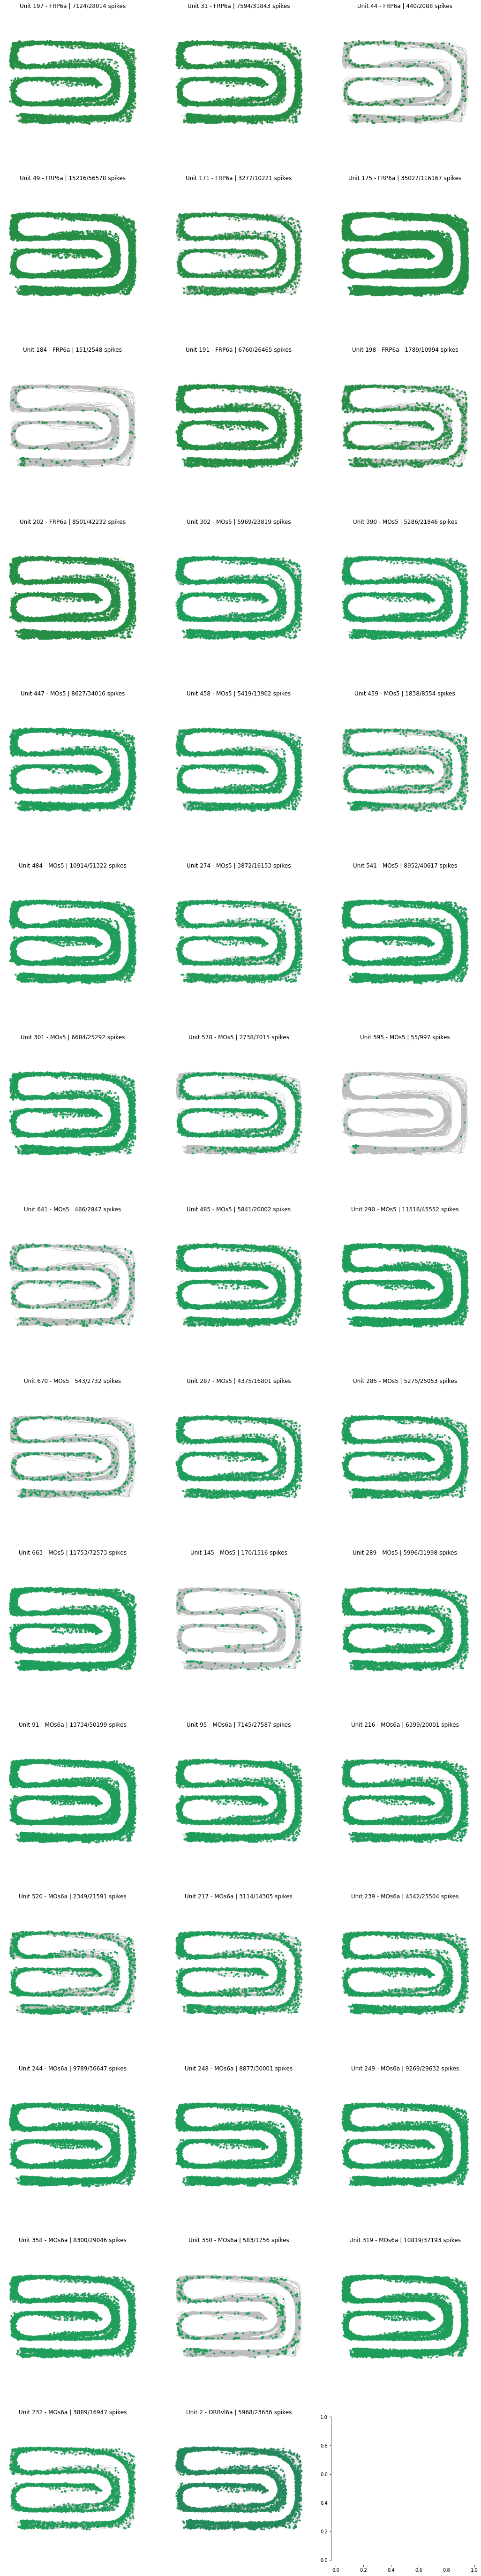

In [3]:
SPEED_TH = 10  # only show spikes when mouse is going faster than this, in cm/s




fast = np.where(tracking["speed"] > SPEED_TH)[0]

# spikes = unit.spikes



f, axes = plt.subplots(np.ceil(len(units)/3).astype(int), 3, figsize=(18, 100))
# f.suptitle(f"{REC} - locomotion onset")

for (i, unit), ax in zip(units.iterrows(), axes.flatten()):
    spikes = unit.spikes[np.isin(unit.spikes, fast)]
    ax.set(title=f"Unit {unit.unit_id} - {unit.brain_region} | {len(spikes)}/{len(unit.spikes)} spikes")


    ax.plot(tracking.y[fast], tracking.x[fast], color=grey, lw=.5)
    ax.scatter(tracking.y[spikes], tracking.x[spikes], color=unit.color, s=10, alpha=1, zorder=100)

    ax.axis("equal")
    ax.axis("off")

clean_axes(f)
f.savefig(save_folder / f"{REC}_units_xy_heatmaps.png", dpi=100, bbox_inches="tight")